In [18]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import numpy as np
from h5py import File

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"/figures/output/presentation_figures")

rc = {
    # "figure.facecolor": "#FFFFFF00",
    # "axes.facecolor": "#FFFFFF00",
    "legend.framealpha": 0.2,
    "lines.color": "k",
    "svg.fonttype": "none",
}

sns.set_context("talk")
sns.set_theme(style="ticks", font="Arial", rc=rc)

# print(mpl.font_manager.get_font_names())
nc_pal = {cycle: col for cycle, col in zip(
    [10, 11, 12, 13, 14],
    ["#555555", "#44af69", "#f8333c", "#fcab10", "#2b9eb3"]
)}
trk_pal = ["steelblue", "gold"]
four_color_pal = ["#44af69", "#f8333c", "#fcab10", "#2b9eb3"]
spots_dfs = []
metadatas = []
stems = []

for i, spots_path in tqdm(enumerate(spots_directory.glob("*_spots.h5")), desc="reading spots dfs"):
    # print(spots_path)
    spots_df = pd.read_hdf(spots_path, key="df")
    stems.append(spots_path.stem)

    spots_df["source"] = i

    metadata = {}

    with File(spots_path, "r") as f:
        m = f["metadata"]
        metadata.update(m.attrs)

    metadatas.append(metadata)

    # print(metadata)

    dtw_path = spots_directory / "dtw" / f"{spots_path.stem}_dtw.h5"
    if dtw_path.exists():
        dtw_update = pd.read_hdf(dtw_path, key="df")
        spots_df = pd.merge(
            spots_df, dtw_update, left_index=True, right_index=True, how="left"
        )
        spots_df["cycle_pseudotime"] = spots_df["pseudotime"] + spots_df["cycle"] - 11
    else:
        spots_df["distance"] = np.nan  # rename this later
        spots_df["pseudotime"] = np.nan

    spots_dfs.append(spots_df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


reading spots dfs: 14it [00:13,  1.01it/s]


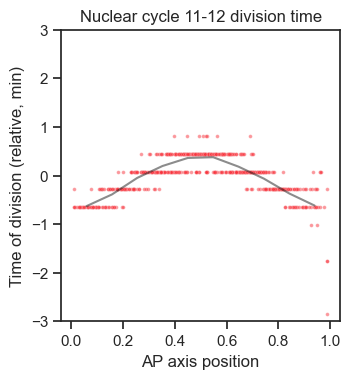

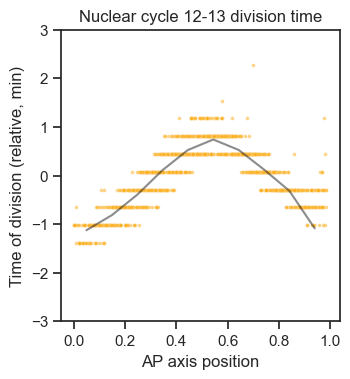

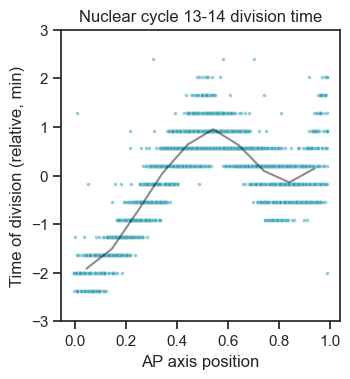

In [36]:
i = 0

spots_df = spots_dfs[i]
stem = stems[i]

for cycle in [11, 12, 13]:

    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    plt.tight_layout(rect=(0.05, 0.05, 0.95, 0.95))

    color = nc_pal[cycle + 1]

    spots_df = spots_df[spots_df["AP"] < 0.99]
    spots_df = spots_df[spots_df["distance"] < 3.5]

    t = spots_df[spots_df["cycle"] == cycle].groupby("tracklet_id")

    x = pd.cut(t["AP"].last(), 10)
    x = x.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time_since_nc11"].max())

    y = y - np.mean(y)

    legend = False

    sns.lineplot(x=x, y=y, ax=ax, color="k", legend=legend, errorbar=None, alpha=0.5)
    sns.scatterplot(x=t["AP"].last(), y=y, ax=ax, color=color, s=7, alpha=0.5)

    ax.set_xlabel("AP axis position")
    ax.set_ylabel("Time of division (relative, min)")

    ax.set_title(f"Nuclear cycle {cycle}-{cycle + 1} division time")

    ax.set_ylim([-3, 3])

    plt.savefig(save_path / "waves" / f"{stem}_NC_{cycle}_division_time.png", dpi=300)
    plt.show()


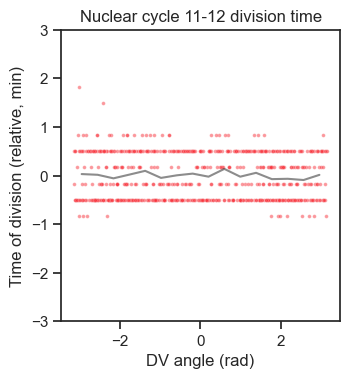

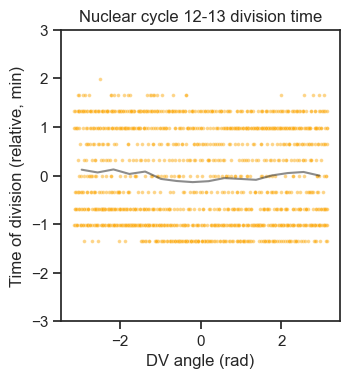

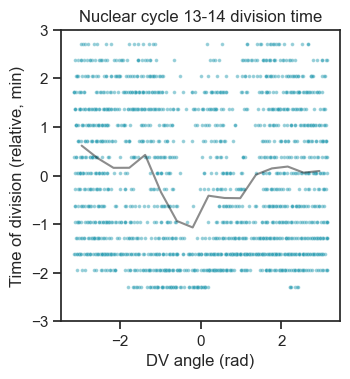

In [39]:
i = 5

spots_df = spots_dfs[i]
stem = stems[i]


for cycle in [11, 12, 13]:
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    plt.tight_layout(rect=(0.05, 0.05, 0.95, 0.95))

    color = nc_pal[cycle + 1]

    spots_df = spots_df[spots_df["AP"] < 0.99]
    spots_df = spots_df[spots_df["distance"] < 3.5]

    t = spots_df[spots_df["cycle"] == cycle].groupby("tracklet_id")

    x = pd.cut(t["theta"].last(), 16)
    x = x.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time_since_nc11"].max())

    y = y - np.mean(y)

    legend = False

    sns.lineplot(x=x, y=y, ax=ax, color="k", legend=legend, errorbar=None, alpha=0.5)
    sns.scatterplot(x=t["theta"].last(), y=y, ax=ax, color=color, s=7, alpha=0.5)

    ax.set_xlabel("DV angle (rad)")
    ax.set_ylabel("Time of division (relative, min)")

    ax.set_title(f"Nuclear cycle {cycle}-{cycle + 1} division time")

    ax.set_ylim([-3, 3])

    plt.savefig(save_path / "waves" / f"{stem}_NC_{cycle}_division_time_theta.png", dpi=300)
    plt.show()


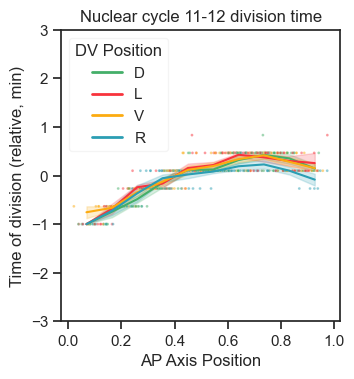

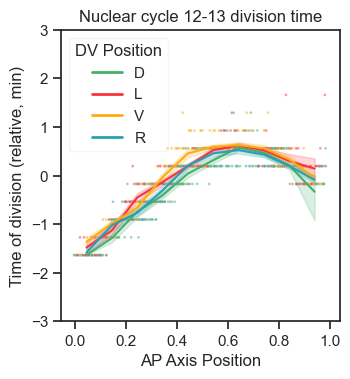

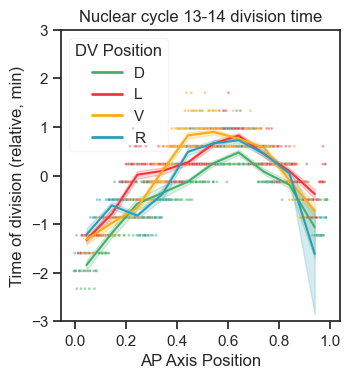

In [92]:
from matplotlib.lines import Line2D

i = 1

spots_df = spots_dfs[i]
stem = stems[i]


for cycle in [11, 12, 13]:
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    plt.tight_layout(rect=(0.05, 0.05, 0.95, 0.95))

    spots_df = spots_df[spots_df["AP"] < 0.99]
    spots_df = spots_df[spots_df["distance"] < 3.5]

    t = spots_df[spots_df["cycle"] == cycle].groupby("tracklet_id")

    x = pd.cut(t["AP"].last(), 10)
    x = x.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time_since_nc11"].max())

    hue = (t["theta"].mean() // (np.pi/2) + 2).astype(int)

    y = y - np.mean(y)

    legend = False

    sns.lineplot(x=x, y=y, ax=ax, hue=hue, palette=four_color_pal, legend=legend)
    sns.scatterplot(x=t["AP"].last(), y=y, ax=ax, hue=hue, palette=four_color_pal, legend=legend, s=4, alpha=0.5)

    ax.set_xlabel("AP Axis Position")
    ax.set_ylabel("Time of division (relative, min)")

    ax.set_title(f"Nuclear cycle {cycle}-{cycle + 1} division time")

    ax.set_ylim([-3, 3])

    custom_lines = [Line2D([0], [0], color=four_color_pal[i], lw=2) for i in range(4)]
    ax.legend(custom_lines, ["D", "L", "V", "R"], title="DV Position", loc="upper left")

    plt.savefig(save_path / "waves" / f"{stem}_NC_{cycle}_division_time_DV.png", dpi=300)
    plt.show()





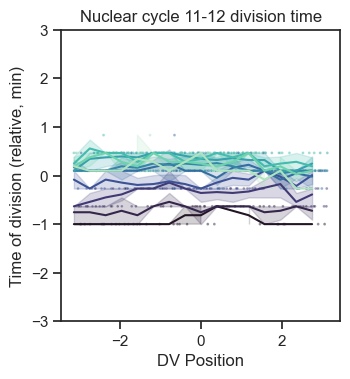

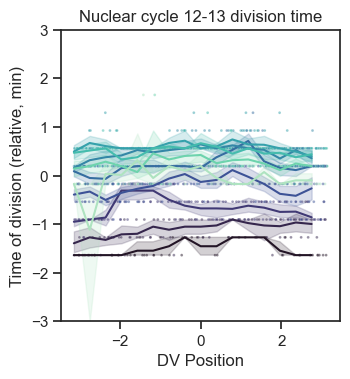

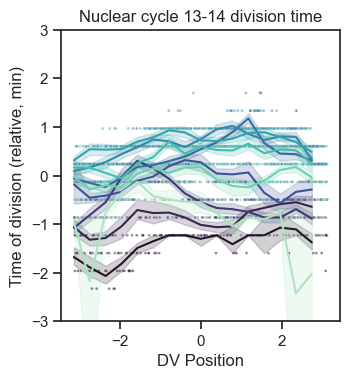

In [54]:
from matplotlib.lines import Line2D

i = 1

spots_df = spots_dfs[i]
stem = stems[i]


for cycle in [11, 12, 13]:
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    plt.tight_layout(rect=(0.05, 0.05, 0.95, 0.95))

    spots_df = spots_df[spots_df["AP"] < 0.99]
    spots_df = spots_df[spots_df["distance"] < 3.5]

    t = spots_df[spots_df["cycle"] == cycle].groupby("tracklet_id")

    hue = pd.cut(t["AP"].last(), 10)
    hue = hue.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time_since_nc11"].max())

    x = (t["theta"].last() // (np.pi/8)) * np.pi/8

    y = y - np.mean(y)

    legend = False

    sns.lineplot(x=x, y=y, ax=ax, hue=hue, palette="mako", legend=legend)
    sns.scatterplot(x=t["theta"].last(), y=y, ax=ax, hue=hue, palette="mako", legend=legend, s=4, alpha=0.5)

    ax.set_xlabel("DV Position")
    ax.set_ylabel("Time of division (relative, min)")

    ax.set_title(f"Nuclear cycle {cycle}-{cycle + 1} division time")

    ax.set_ylim([-3, 3])

    # custom_lines = [Line2D([0], [0], color=four_color_pal[i], lw=2) for i in range(4)]
    # ax.legend(custom_lines, ["D", "L", "V", "R"], title="DV Position", loc="upper left")

    plt.savefig(save_path / "waves" / f"swap_{stem}_NC_{cycle}_division_time_DV.png", dpi=300)
    plt.show()





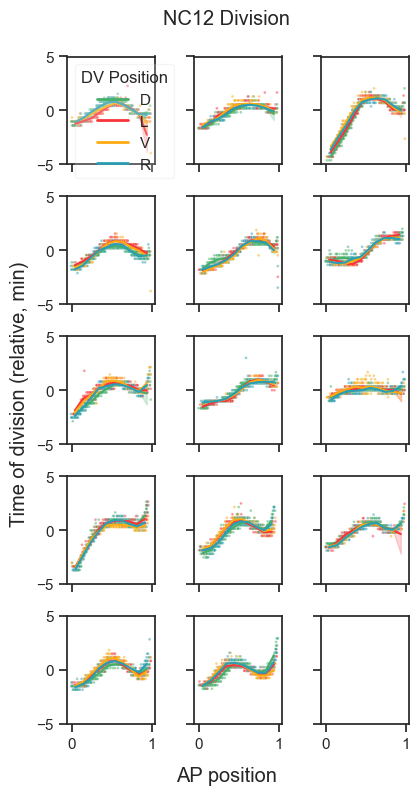

In [49]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(5, 3, figsize=(4.5, 8), sharex=True, sharey=True)
cycle = 12

plt.tight_layout(rect=(0.03, 0.03, 0.97, 0.95))


for i, (df, ax) in enumerate(zip(spots_dfs[0:], axes.flatten())):

    trk = df["trk"].min()

    color = trk_pal[int(trk)]

    df = df[df["AP"] < 0.99]
    df = df[df["distance"] < 3.5]

    t = df[df["cycle"] == cycle].groupby("tracklet_id")

    hue = (t["theta"].mean() // (np.pi/2) + 2).astype(int)

    x = pd.cut(t["AP"].last(), 10)
    x = x.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time_since_nc11"].max())

    y = y - np.mean(y)

    legend = False

    sns.lineplot(x=x, y=y, ax=ax, hue=hue, palette=four_color_pal, legend=legend)
    sns.scatterplot(x=t["AP"].last(), y=y, ax=ax, hue=hue, palette=four_color_pal, legend=legend, s=4, alpha=0.5)

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.set_ylim([-5, 5])

#
custom_lines = [Line2D([0], [0], color=four_color_pal[i], lw=2) for i in range(4)]

axes.flatten()[0].legend(custom_lines, ["D", "L", "V", "R"], title="DV Position", loc="upper left")

fig.supxlabel("AP position")
fig.supylabel("Time of division (relative, min)")

plt.suptitle(f"NC{cycle} Division")

plt.savefig(save_path / f"ap_division_time_{cycle}_line_dvsplit_scatter_Trk.png")
plt.show()

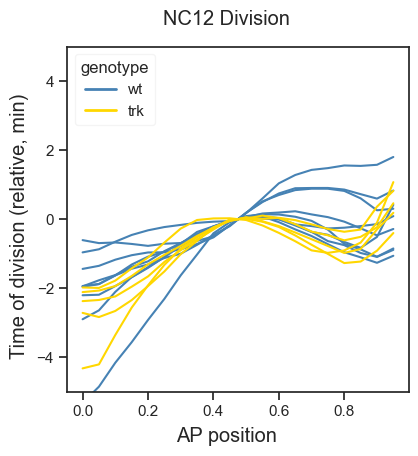

In [79]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
cycle = 12

plt.tight_layout(rect=(0.03, 0.03, 0.97, 0.95))

all_wt = []
all_trk = []


for i, df in enumerate(spots_dfs[0:]):

    trk = df["trk"].min()

    color = trk_pal[int(trk)]

    # df = df[(df["AP"] > 0.8)]

    df["AP_last"] = df["tracklet_id"].map(df.groupby("tracklet_id")["AP"].last())
    df["AP_last_bin"] = df["AP_last"] // 0.05 * 0.05
    df = df[df["AP_last"].between(0.02, 0.98)]

    df = df[df["distance"] < 3.5]

    t = df[df["cycle"] == cycle].groupby("tracklet_id")


    # hue = (t["theta"].mean() // (np.pi/2) + 2).astype(int)

    x = t["AP"].last() // 0.05 * 0.05
    y = np.array(t["time_since_nc11"].max())

    anchor = np.mean(t["time_since_nc11"].max().values[t["AP"].last().between(0.45, 0.55)])

    y = y - anchor

    legend = False

    sns.lineplot(x=x, y=y, ax=ax, color=color, legend=legend, errorbar=None, alpha=0.3)
    # sns.scatterplot(x=t["AP"].last(), y=y, ax=ax, hue=hue, palette=four_color_pal, legend=legend, s=4, alpha=0.5)

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.set_ylim([-5, 5])

    # gb =

#
custom_lines = [Line2D([0], [0], color=trk_pal[i], lw=2) for i in range(2)]

ax.legend(custom_lines, ["wt", "trk"], title="genotype", loc="upper left")

fig.supxlabel("AP position")
fig.supylabel("Time of division (relative, min)")

plt.suptitle(f"NC{cycle} Division")

plt.savefig(save_path / f"ap_division_time_{cycle}_trk_all.png")
plt.show()

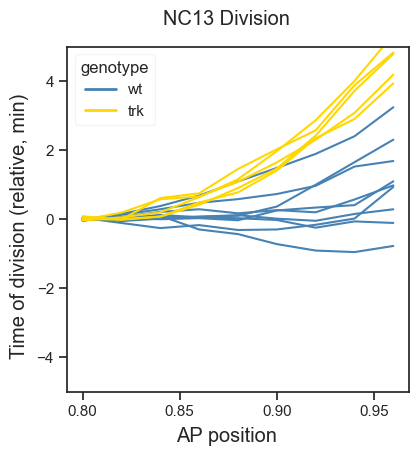

In [73]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
cycle = 13

plt.tight_layout(rect=(0.03, 0.03, 0.97, 0.95))


for i, df in enumerate(spots_dfs[0:]):

    trk = df["trk"].min()

    color = trk_pal[int(trk)]

    # df = df[(df["AP"] > 0.8)]

    df["AP_last"] = df["tracklet_id"].map(df.groupby("tracklet_id")["AP"].last())
    df = df[df["AP_last"].between(0.80, 0.98)]

    df = df[df["distance"] < 7]

    t = df[df["cycle"] == cycle].groupby("tracklet_id")


    # hue = (t["theta"].mean() // (np.pi/2) + 2).astype(int)

    x = t["AP"].last() // 0.02 * 0.02
    y = np.array(t["time_since_nc11"].max())

    anchor = np.mean(t["time_since_nc11"].max().values[t["AP"].last().between(0.77, 0.83)])

    y = y - anchor

    legend = False

    sns.lineplot(x=x, y=y, ax=ax, color=color, legend=legend, errorbar=None)
    # sns.scatterplot(x=t["AP"].last(), y=y, ax=ax, hue=hue, palette=four_color_pal, legend=legend, s=4, alpha=0.5)

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.set_ylim([-5, 5])

#
custom_lines = [Line2D([0], [0], color=trk_pal[i], lw=2) for i in range(2)]

ax.legend(custom_lines, ["wt", "trk"], title="genotype", loc="upper left")

fig.supxlabel("AP position")
fig.supylabel("Time of division (relative, min)")

plt.suptitle(f"NC{cycle} Division")

plt.savefig(save_path / f"ap_division_time_{cycle}_trk_posterior.png")
plt.show()

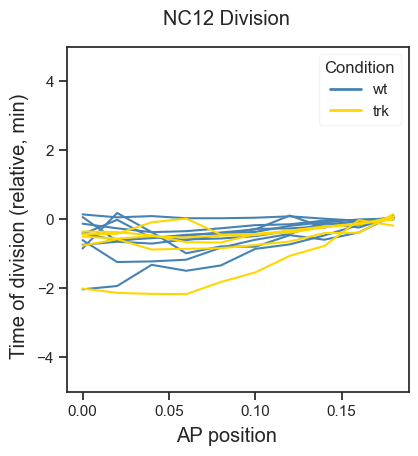

In [71]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
cycle = 12

plt.tight_layout(rect=(0.03, 0.03, 0.97, 0.95))


for i, df in enumerate(spots_dfs[0:]):

    trk = df["trk"].min()

    color = trk_pal[int(trk)]

    # df = df[(df["AP"] > 0.8)]

    df["AP_last"] = df["tracklet_id"].map(df.groupby("tracklet_id")["AP"].last())
    df = df[df["AP_last"].between(0.0, 0.2)]

    df = df[df["distance"] < 7]

    t = df[df["cycle"] == cycle].groupby("tracklet_id")


    # hue = (t["theta"].mean() // (np.pi/2) + 2).astype(int)

    x = t["AP"].last() // 0.02 * 0.02
    y = np.array(t["time_since_nc11"].max())

    anchor = np.mean(t["time_since_nc11"].max().values[t["AP"].last().between(0.17, 0.23)])

    y = y - anchor

    legend = False

    sns.lineplot(x=x, y=y, ax=ax, color=color, legend=legend, errorbar=None)
    # sns.scatterplot(x=t["AP"].last(), y=y, ax=ax, hue=hue, palette=four_color_pal, legend=legend, s=4, alpha=0.5)

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.set_ylim([-5, 5])

#
custom_lines = [Line2D([0], [0], color=trk_pal[i], lw=2) for i in range(2)]

ax.legend(custom_lines, ["wt", "trk"], title="Condition", loc="upper right")

fig.supxlabel("AP position")
fig.supylabel("Time of division (relative, min)")

plt.suptitle(f"NC{cycle} Division")

plt.savefig(save_path / f"ap_division_time_{cycle}_trk_anterior.png")
plt.show()

In [ ]:
from scipy.spatial.distance import cdist

anterior_densities = []
posterior_densities = []
center_densities = []
ap_density = []
trks = []



for df in spots_dfs:

    fig, ax = plt.subplots(figsize=(6, 4))

    df = df.copy()
    end_frame = df["frame"].max()
    trk = df["trk"].iloc[0]

    subset = df[df["frame"] == end_frame]

    def to_parametric(coeffs, thetas):
        cs = np.cos(thetas)
        sn = np.sin(thetas)

        l1 = coeffs[0] * cs**2 + coeffs[1] * cs * sn + coeffs[2] * sn**2
        l2 = coeffs[3] * cs + coeffs[4] * sn

        rvals = (-l1 + np.sqrt(l2**2 + 4*l1)) / (2*l1 + 1e-10)

        return rvals

    xv = []
    zv = []
    yv = []

    n = 1000
    goldenRatio = (1 + 5**0.5)/2
    i = np.arange(0, n)
    thetas = 2 *np.pi * i / goldenRatio
    phi = np.arccos(1 - 2*(i+0.5)/n)
    ap_pos = np.cos(phi) / 2 + 0.5

    for point, theta in zip(ap_pos, thetas):
        data = subset[subset["AP"].between(point - 0.025, point + 0.025)]

        X = np.expand_dims(data["x"].values, -1)
        Y = np.expand_dims(data["z"].values, -1)

        xmean = X.mean()
        ymean = Y.mean()

        X = X - X.mean()
        Y = Y - Y.mean()

        A = np.hstack([X**2, X * Y, Y**2, X, Y])
        b = np.ones_like(X)
        x = np.linalg.lstsq(A, b)[0].squeeze()

        # thetas = np.linspace(0, 2 * np.pi, 100)
        rvals = to_parametric(x, theta)

        xv.append(rvals * np.cos(theta) + xmean)
        zv.append(rvals * np.sin(theta) + ymean)
        yv.append(np.mean(data["y"]))

    start_frame = int(np.max(df["frame"].values[df["time_since_nc11"] < -3]))

    for frame, name in zip([start_frame, end_frame], ["NC 10", "NC 14"]):

        frame_subset = df[df["frame"] == frame]
        dis = cdist(
            np.array([xv, yv, zv]).T,
            frame_subset[["x", "y", "z"]].values
        )

        # dis = cdist(
        #     np.array([xv, yv, zv]).T,
        #     np.array([xv, yv, zv]).T
        # )

        print(dis.shape)

        densities = np.sum(dis < 30, axis=1) / dis.shape[1]

        ap_cut = (ap_pos // 0.05) * 0.05
        ap_d = pd.Series(densities).groupby(ap_cut).mean()
        center_val = np.mean([ap_d.loc[0.45], ap_d.loc[0.50]])


        sns.lineplot(x=ap_cut, y=densities / center_val, label=f"frame {frame}", linewidth=2.0, ax=ax)

        if frame == end_frame:

            ap_d = pd.Series(densities).groupby(ap_cut).mean()
            ap_density.append(ap_d)
            trks.append(trk)

            anterior_densities.append(ap_d.loc[0.05])
            posterior_densities.append(ap_d.loc[0.90])
            center_densities.append(np.mean([ap_d.loc[0.45], ap_d.loc[0.50]]))

    # sns.kdeplot(densities, label=f"frame {frame}")

    plt.show()

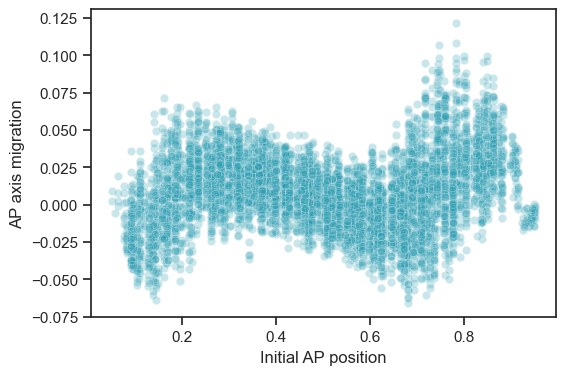

In [91]:
from scipy.stats import linregress

fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharex=True, sharey=True)

slopes = []
x_intercepts = []
trk = []

df = spots_dfs[5]

df = df.copy()

df = df[df["AP"].between(0.05, 0.95)]

df["ap_first"] = df["track_id"].map(df.groupby("track_id")["AP"].first())

df["ap_bin"] = np.round(((df["ap_first"] - 0.05) // 0.10) * 0.10 + 0.05, 2)

df["ap_from_start"] = df["AP"] - df["track_id"].map(
    df.groupby("track_id")["AP"].first()
)

# regression = linregress(
#     df["ap_first"], df["ap_from_start"]
# )

trk.append("trk" if df["trk"][0] else "wt")

# print(regression)

gb = df[df["frame"] == df["frame"].max()].groupby("track_id")
frame_df = df[df["frame"] == df["frame"].max()]

this_df = gb

# sns.violinplot(df[df["frame"] == df["frame"].max()], x="ap_bin", y="ap_from_start", hue="ap_bin", split=True, palette="mako", ax=ax, legend=False)
sns.scatterplot(x=frame_df["ap_first"], y=frame_df["ap_from_start"], color=four_color_pal[-1], ax=ax, legend=False, alpha=0.25)
# sns.scatterplot(x=gb["ap_first"].mean(), y=gb["ap_from_start"].mean(), color=four_color_pal[-2], ax=ax, legend=False, alpha=1.0)
    # sns.lineplot(df[df["frame"] == df["frame"].max()], x="ap_bin", y="ap_from_start", color="k", ax=ax, legend=False, errorbar=None)

plt.ylabel("AP axis migration")
plt.xlabel("Initial AP position")

plt.show()
